In [2]:
import os

os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

In [4]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [8]:
ds_ll = faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [9]:
#ds.dt 
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time[1:-1].values 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#mask
def atlMask(newMask):
    #mask[ydimension, xdimnesion]
    newMask[215:, 0:147] = 0 #fixes top left pixel
    newMask[215:, 260:] = 0
    newMask[185:215, :120] = 0
    newMask[185:215, 260:] = 0 #right 
    newMask[185:199, 250:] = 0 #right
    newMask[:185, :133] = 0 #responsible for bottom left pixel
    newMask[:180, :141] = 0 #fixse bottom left pixeel 
    newMask[:185, 245:] = 0
    newMask[115:145, 135:155] = 0
    for j in coords.j[55:125]:
        for i in coords.i[205:245]:
            if j < (7/4)*i - 303.75:
                newMask[j,i] = 0
    return newMask
mask = atlMask(coords.hFacS.isel(k=0).load())

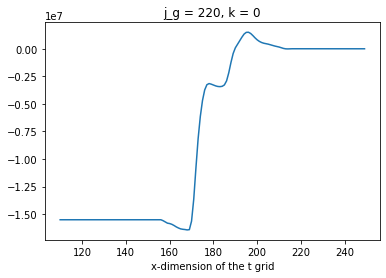

In [10]:
#Top volume flux -> 15511280.39047292
tr = (ds.LaVH3RHO * coords.dxG * mask)[:, :103, 220, :].sum('l3_c')
tr1 = (tr*ds.dt).sum('time')/ds.dt.sum('time')
top_region = (tr1.cumsum('i') - 15511280)[110:250]
top_region.plot()

In [17]:
top_region = (tr1.cumsum('i') - 15511280)[110:250]
top_region

<xarray.DataArray (i: 140)>
dask.array<shape=(140,), dtype=float64, chunksize=(70,)>
Coordinates:
    j_g      int64 220
  * i        (i) int64 110 111 112 113 114 115 116 ... 244 245 246 247 248 249
    k        int64 0

In [66]:
np.argmax(top_region.values>0)

80

In [70]:
top_region[80].values

array(85348.4407521)

In [74]:
top_region[79].values

array(-431765.09999641)